IMPORT PACKAGE

In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

DATA INPUT

In [ ]:
df = pd.read_csv("jabodetabek_house_price.csv")

PREPROCESSING DATA

In [25]:
df.isnull().sum()

url                        0
price_in_rp                0
title                      0
address                    0
district                   0
city                       0
lat                        0
long                       0
facilities                 0
property_type              1
ads_id                     4
bedrooms                  34
bathrooms                 29
land_size_m2               2
building_size_m2           2
carports                   0
certificate              141
electricity                0
maid_bedrooms              0
maid_bathrooms             0
floors                     6
building_age            1445
year_built              1445
property_condition       246
building_orientation    1647
garages                    0
furnishing               387
dtype: int64

In [26]:
df.drop(columns=['url','title', 'lat', 'long','city','ads_id',
                 'building_age', 'year_built', 'property_condition',
                 'building_orientation', 'address','floors','district','property_type','certificate'], inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3144 entries, 0 to 3552
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_in_rp       3144 non-null   float64
 1   facilities        3144 non-null   object 
 2   bedrooms          3144 non-null   float64
 3   bathrooms         3144 non-null   float64
 4   land_size_m2      3144 non-null   float64
 5   building_size_m2  3144 non-null   float64
 6   carports          3144 non-null   float64
 7   electricity       3144 non-null   object 
 8   maid_bedrooms     3144 non-null   float64
 9   maid_bathrooms    3144 non-null   float64
 10  garages           3144 non-null   float64
 11  furnishing        3144 non-null   object 
dtypes: float64(9), object(3)
memory usage: 319.3+ KB


In [27]:
df = df[df['bedrooms'] <= 13]
df = df[~df['electricity'].str.contains("lainnya", case=False, na=False)]
df['electricity'] = df['electricity'].str.replace(' mah', '', case=False).astype(float)

#Furnisihing
furnish_mapping = {
    "unfurnished": 0,
    "semi furnished": 1,
    "furnished": 2,
}
df['furnishing'] = df['furnishing'].map(furnish_mapping).astype(float)

#Fasilitas
def count_facilities(facilities_string):
    fasilitas_list = [fasilitas.strip() for fasilitas in facilities_string.split(",")]
    return len(fasilitas_list)
df['facility_count'] = df['facilities'].apply(count_facilities)
df = df[df['facility_count'] >= 2]
df = df.drop(columns=['facility_count'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2796 entries, 0 to 3552
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_in_rp       2796 non-null   float64
 1   facilities        2796 non-null   object 
 2   bedrooms          2796 non-null   float64
 3   bathrooms         2796 non-null   float64
 4   land_size_m2      2796 non-null   float64
 5   building_size_m2  2796 non-null   float64
 6   carports          2796 non-null   float64
 7   electricity       2796 non-null   float64
 8   maid_bedrooms     2796 non-null   float64
 9   maid_bathrooms    2796 non-null   float64
 10  garages           2796 non-null   float64
 11  furnishing        2796 non-null   float64
dtypes: float64(11), object(1)
memory usage: 284.0+ KB


In [28]:
facility_weights = {
    #-------------- Peralatan
    'AC': 8,
    'Ac': 8,
    'Kulkas': 8,
    'Mesin Cuci': 8,
    'Pemanas Air': 5,
    'Water heater': 5,
    'Kompor': 3,
    'Wastafel': 2,
    #-------------- Rumah Tangga
    'Kitchen Set': 5,
    'Kitchen set': 5,
    'Tempat Jemuran': 5,
    'Tempat Laundry': 5,
    'Free kitchen set': 5,
    #--------- Lingkungan
    'Jogging Track': 5,
    'Playground': 5,
    'Tempat Gym': 5,
    'Track Lari': 5,
    'Lapangan Voli': 5,
    'Lapangan Tenis': 5,
    'Lapangan Bola': 5,
    'Lapangan Bulu Tangkis': 5,
    'Lapangan Basket': 5,
    'Clubhouse': 10,
    'Akses Parkir': 4,
    #--------------------- Hiburan
    'Kolam Ikan': 5,
    'Taman': 5,
    'Garden': 5,
    'Pool': 10,
    'Kolam Renang': 10,
    'Private Pool': 10,
    'Backyard luas': 5,
    'Swimming Pool': 10,
    'Taman minimalis': 5,
    #--------------------------- Security
    'Smarthome': 10,
    'Smart Home': 10,
    'Smart lock door': 10,
    'Keamanan': 12,
    'Security 24 jam': 12,
    'CCTV': 10,
    'CCTV area': 10,
    'Onegate': 10,
    'Security 24H': 12,
    'Keamanan 24 jam': 12,
    'One Gate System': 10,
    #-------------Add On
    'Masjid': 10,
    'Mushola': 5,
    'Jalur Telepon': 3,
    'Posisi hoek': 5,
    'Canopy': 3,
    'Jetpump': 3,
    'Basement': 5,
    'Gudang': 5,
    'Pagar': 3,
    'Service area': 3
}

# Step 2: Calculate total weight for each row
def calculate_total_weight(facilities_string):
    if pd.isna(facilities_string):
        return 0
    facilities = [facility.strip() for facility in facilities_string.split(',')]
    return sum(facility_weights.get(facility, 0) for facility in facilities)

# Apply the function to the 'facilities' column
df['total_weight_facilities'] = df['facilities'].apply(calculate_total_weight).astype(float)

df = df.drop(columns=['facilities'])

In [29]:
df['total_weight_facilities'] = df['total_weight_facilities'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2796 entries, 0 to 3552
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price_in_rp              2796 non-null   float64
 1   bedrooms                 2796 non-null   float64
 2   bathrooms                2796 non-null   float64
 3   land_size_m2             2796 non-null   float64
 4   building_size_m2         2796 non-null   float64
 5   carports                 2796 non-null   float64
 6   electricity              2796 non-null   float64
 7   maid_bedrooms            2796 non-null   float64
 8   maid_bathrooms           2796 non-null   float64
 9   garages                  2796 non-null   float64
 10  furnishing               2796 non-null   float64
 11  total_weight_facilities  2796 non-null   float64
dtypes: float64(12)
memory usage: 284.0 KB


In [30]:
df.corr()["price_in_rp"].sort_values(ascending=False)

price_in_rp                1.000000
building_size_m2           0.442703
electricity                0.421167
land_size_m2               0.300795
maid_bedrooms              0.297802
bathrooms                  0.294977
maid_bathrooms             0.288047
bedrooms                   0.267323
garages                    0.241446
carports                   0.227304
furnishing                 0.100002
total_weight_facilities    0.035216
Name: price_in_rp, dtype: float64

<Axes: >

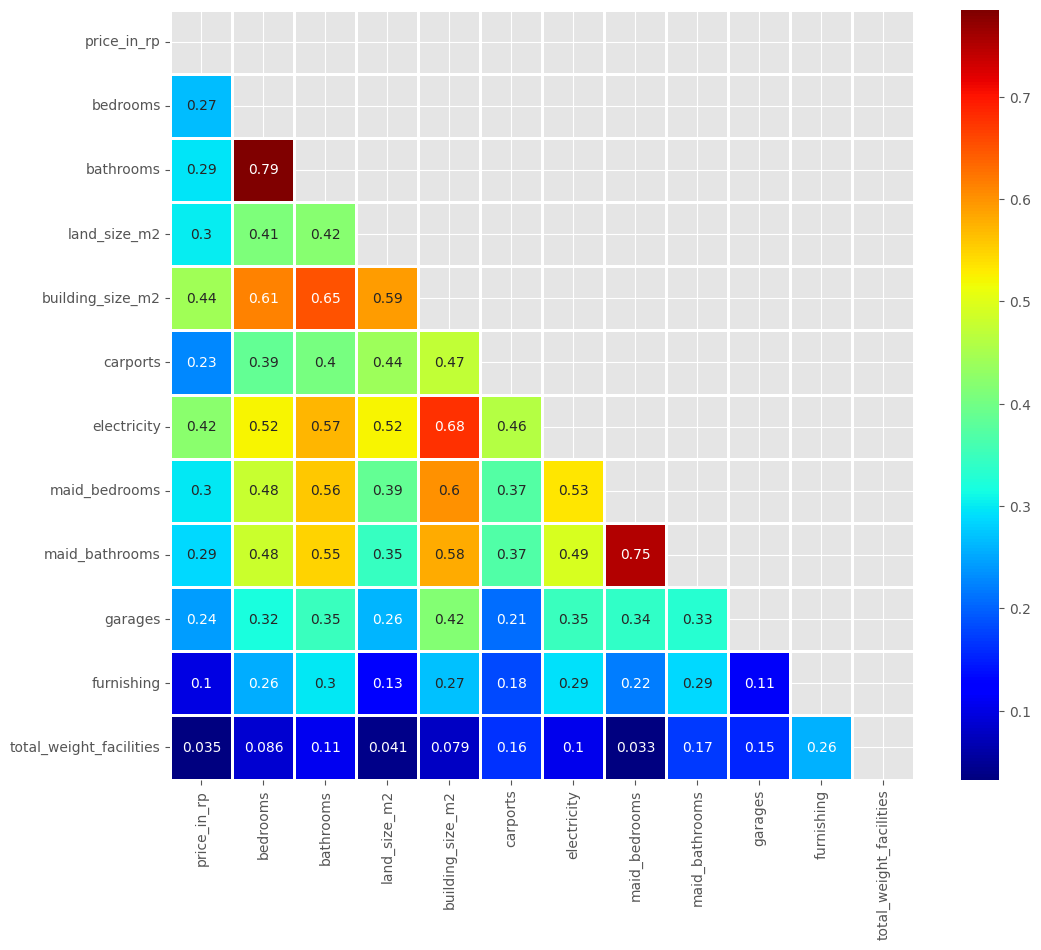

In [31]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=df.corr(), cmap="jet", annot=True,linewidths=1, linecolor='white',mask=mask)

MODEL INITIALISING

In [32]:
X = df.drop(["price_in_rp"], axis=1).values
y = df["price_in_rp"].values
print(X)
print(y)
input_dim = X.shape[1]
print(input_dim)

[[  4.   4. 239. ...   0.   0.  18.]
 [  3.   3. 119. ...   1.   0.  45.]
 [  3.   3. 180. ...   2.   0.  68.]
 ...
 [  3.   2.  78. ...   0.   0.  45.]
 [  3.   2.  60. ...   0.   2.  46.]
 [  3.   2.  64. ...   2.   1.  92.]]
[2.99e+09 1.95e+09 3.30e+09 ... 7.55e+08 8.00e+08 6.55e+08]
11


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2516, 11)
(280, 11)
(2516,)
(280,)


In [34]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
y_train = np.log(y_train)
y_test = np.log(y_test)

TRAINING MODEL

In [35]:
ann = Sequential([
    Dense(128, input_dim=input_dim, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])

# ann = Sequential([
#     Dense(64, input_dim=input_dim, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(16, activation='relu'),
#     Dense(1, activation='linear')
# ])

ann.summary()

c:\Users\LOQ\Documents\PERKULIAHAN\FILE TUGAS KULIAH\SEMESTER 7\MACHINE LEARNING\Coding\venvml\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
def r2_score(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

ann.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ann.fit(X_train, y_train,
          epochs=240,
          batch_size=32,
          validation_split=0.1,
          )
#callbacks=[early_stopping]

Epoch 1/240
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 148.1426 - mean_absolute_error: 9.2201 - mean_squared_error: 148.1426 - val_loss: 11.1034 - val_mean_absolute_error: 1.9697 - val_mean_squared_error: 11.1034
Epoch 2/240
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9224 - mean_absolute_error: 1.9302 - mean_squared_error: 7.9224 - val_loss: 7.8599 - val_mean_absolute_error: 2.2379 - val_mean_squared_error: 7.8599
Epoch 3/240
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2410 - mean_absolute_error: 1.4961 - mean_squared_error: 4.2410 - val_loss: 5.9211 - val_mean_absolute_error: 1.8165 - val_mean_squared_error: 5.9211
Epoch 4/240
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5546 - mean_absolute_error: 1.1062 - mean_squared_error: 2.5546 - val_loss: 1.3150 - val_mean_absolute_error: 0.6150 - val_mean_squared_error: 1.3150
Epoch 5/240
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8815 - mean_absolute_error: 0.6272 - mean_squared_error: 0.8815 - val_loss: 0.8434 - val_

In [38]:
# Evaluate the model
loss, mae, mse = ann.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")
print(f"Test MSE: {mse}")

# Make predictions
y_pred = ann.predict(X_test)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Test MAPE: {mape}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2386 - mean_absolute_error: 0.3792 - mean_squared_error: 0.2386 
Test MAE: 0.34437111020088196
Test MSE: 0.19049625098705292
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test MAPE: 4.969619328117305


MODEL PERFORMANCE

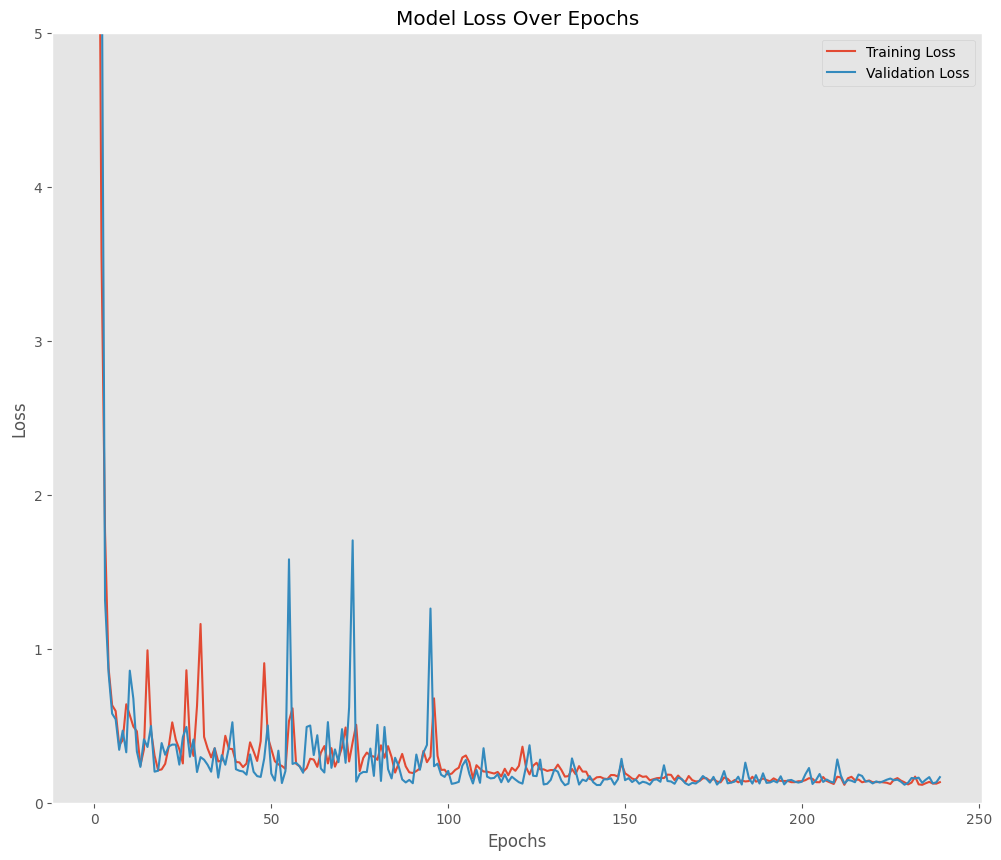

In [39]:
history_df = pd.DataFrame(history.history)

# Set the plot style
plt.style.use("ggplot")

# Create the plot
plt.figure(figsize=(12, 10))

# Plot the relevant metrics
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')

# Set the y-axis limits to focus on the range 0-1
plt.ylim(0, 5)

# Add titles and labels
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid()

# Show the plot
plt.show()

In [40]:
predictions = ann.predict(X_test)
predictions = np.exp(predictions)
y_label = np.exp(y_test)

print(predictions.shape)
print(y_label.shape)

predictions_df = pd.DataFrame(np.ravel(predictions),columns=["Predictions"])
comparison_df = pd.concat([pd.DataFrame(y_label,columns=["Real Values"]), predictions_df],axis=1)
comparison_df

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(280, 1)
(280,)


,Real Values,Predictions
0,5.510000e+08,4.667978e+08
1,2.800000e+10,9.391061e+09
2,8.500000e+08,1.584158e+09
3,1.800000e+10,7.423218e+09
4,1.650000e+10,2.238560e+09
...,...,...
275,4.200000e+09,1.759957e+09
276,1.000000e+08,4.134929e+08
277,1.200000e+09,1.119726e+09
278,5.000000e+08,5.351588e+08


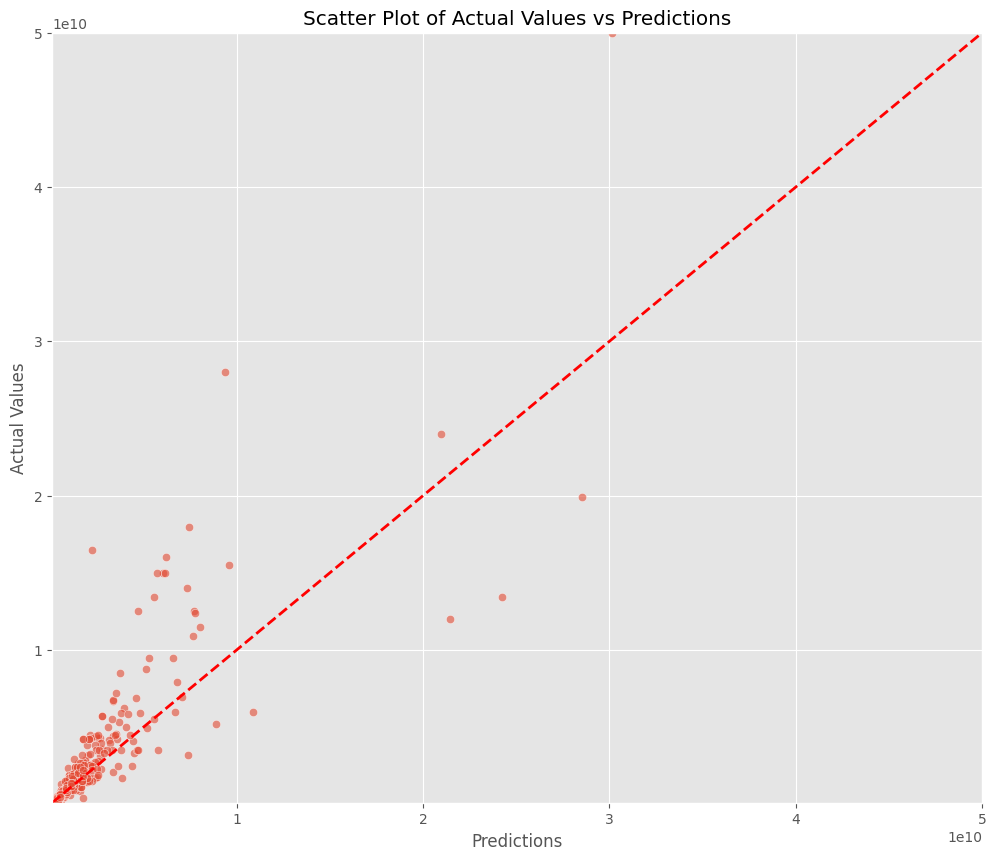

In [41]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=np.ravel(predictions), y=y_label, alpha=0.6)
plt.plot([y_label.min(), y_label.max()], [y_label.min(), y_label.max()], 'r--', lw=2)  # Line of equality
plt.title("Scatter Plot of Actual Values vs Predictions")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")
plt.xlim([y_label.min(), y_label.max()])
plt.ylim([y_label.min(), y_label.max()])
plt.grid(True)
plt.show()

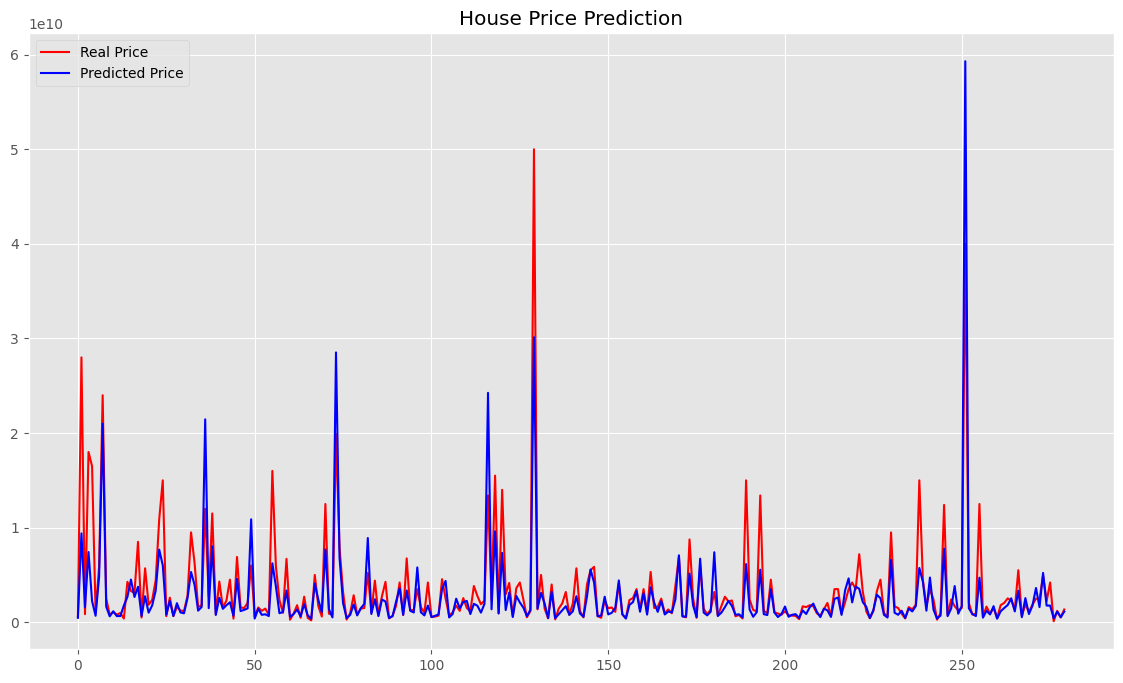

In [44]:
plt.figure(figsize=(14, 8))
plt.plot(y_label, color = 'red', label = 'Real Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Price')
plt.title('House Price Prediction')
plt.legend()
plt.show()